In [4]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings, AverageShiftedHistograms
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

"/home/pbarletta/labo/18/lbp/rtdos_log"

In [5]:
pdb = "4xcp"
# Leo modos
modes_lig, evals_lig = JUMD.read_ptraj_modes(
    joinpath(home, pdb, "lig" ,"pca", string("full_modes_lig_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_lig))
aa = convert(Int64, aa3 / 3)

16

function get_diff(in_avg_filename::AbstractString, in_trj_filename::AbstractString)
    # Get avg ready
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)

    # Estas son las coordenadas q voy a usar p/ restar
    lig_atoms = 2427:2444
    avg_lig_xyz = positions(in_avg_frm)[:, lig_atoms];
    natoms_lig = 2444 - 2427 + 1
    natoms_lig_3 = natoms_lig * 3

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_lig = Array{Float64, 2}(undef, natoms_lig_3, nframes)
    vec_nframes = [ convert(Array{Int64}, collect(0:round(nframes/10):nframes)) ; nframes]

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_lig[:, i+1] = reshape(
                positions(read_step(in_trj, i))[:, lig_atoms] .- avg_lig_xyz, natoms_lig_3)
        end
        println(j)
        close(in_trj)
        GC.gc()
    end
    return diff_lig
end

dif_lig = get_diff(joinpath(home, pdb, "lig", "pca", string("full_avg_lig_", pdb, ".pdb")),
    joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")))

fid = h5open(joinpath(rtdos, string("diff_lig_", pdb, ".h5")), "w")
write(fid, "dif",dif_lig)
close(fid)

In [12]:
dif_lig = h5read(joinpath(rtdos, string("diff_lig_", pdb, ".h5")), "dif")
nframes = size(dif_lig)[2]
norm_dif_lig = mapslices(x -> x ./ norm(x), dif_lig, dims = 1);

prj_1_lig = Array{Float64, 1}(undef, nframes)
prj_2_lig = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 1])
    prj_2_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 2])
end

# Smooth
smooth_prj_1_lig = [ mean(prj_1_lig[i:i+10]) for i = 1:10:length(prj_1_lig)-10 ]
smooth_prj_2_lig = [ mean(prj_2_lig[i:i+10]) for i = 1:10:length(prj_2_lig)-10 ];

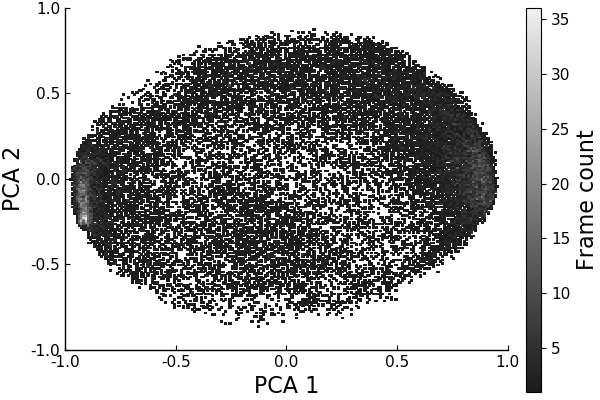

In [141]:
plt_2his = histogram2d(smooth_prj_1_lig, smooth_prj_2_lig, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    nbins = 200, seriescolor = :dimgray, grid = false)

In [142]:
savefig(plt_2his, joinpath(rtdos, "papel", "4", string("4_PCAHis_", pdb, "_lig.svg")))

## Separo las poblaciones según PCA

# Hago esto 1 sola vez
in_bins = collect(-1:.025:1)
his_ind, his = JUMD.MatHisInd2D(prj_1_lig, prj_2_lig, in_bins, in_bins);

msk = his .> 125
main_his = his[msk]
main_his_ind = his_ind[msk];

heatmap(msk[4:7, 27:52])
heatmap(msk[71:78, 35:55])

idx_lig_0 = collect(Iterators.flatten(his_ind[4:9, 27:52]))
idx_lig_1 = collect(Iterators.flatten(his_ind[71:77, 35:55]))

# Indices de poblaciones
writedlm(joinpath(rtdos, string(pdb,"_idx_lig0")), idx_lig_0)
writedlm(joinpath(rtdos, string(pdb,"_idx_lig1")), idx_lig_1);

# Uso esto p/ dividir las trayectorias a escribir en 4 partes y q
# no me llenen la memoria
function scope(idx_vol, in_filename, ou_filename)
    idx_ = convert(Int64, ceil(length(idx_vol) / 10))
    tmp = [ collect(1:idx_:length(idx_vol)) ; length(idx_vol) ]
    ou_trj = Trajectory(ou_filename, 'w')
    for j in 1:length(tmp) - 1
        if j == 1
            in_trj = Trajectory(in_filename)

            for i in tmp[j]:tmp[j+1]
                in_frm = read_step(in_trj, idx_vol[i] - 1)
                write(ou_trj, in_frm)
            end
            close(in_trj)
        else
            in_trj = Trajectory(in_filename)
            
            for i in tmp[j]+1:tmp[j+1]
                in_frm = read_step(in_trj, idx_vol[i] - 1)
                write(ou_trj, in_frm)
            end
            close(in_trj)
        end
        println(j)
        gc()
    end
    close(ou_trj)
end

function filter_trj(indices::Array{Int64, 1},
    in_filename::AbstractString, ou_filename::AbstractString)
    # Divide la corrida en 10 secciones
    idx_ = convert(Int64, ceil(length(indices) / 10))
    secc = [ collect(1:idx_:length(indices)) ; length(indices) ]
    secc[end] += 1
    
    ou_trj = Trajectory(ou_filename, 'w')
    for j in 1:length(secc) - 1
        in_trj = Trajectory(in_filename)
        for i in secc[j]:secc[j+1]-1
            in_frm = read_step(in_trj, indices[i] - 1)
            write(ou_trj, in_frm)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end
    close(ou_trj)
end

# Prote alineadas
filter_trj(idx_lig_0, joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig0", "_", pdb, ".nc")))
filter_trj(idx_lig_1, joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig1", "_", pdb, ".nc")))
    
# Lig alineadas
filter_trj(idx_lig_0, joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig0", "_", pdb, "_ligaligned.nc")))
filter_trj(idx_lig_1, joinpath(home, pdb, "lig", "pca", string("full_avgfit_lig_", pdb, ".nc")),
    joinpath(home, pdb, "lig", "poblaciones", string("lig1", "_", pdb, "_ligaligned.nc")))

In [66]:
idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig0")))[:, 1])
idx_lig_1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig1")))[:, 1])

# Leo volumen
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Estiro el volumen 
full_trj_vol = Array{Float64}(undef, length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_lig_0]
trj_vol1 = full_trj_vol[idx_lig_1];

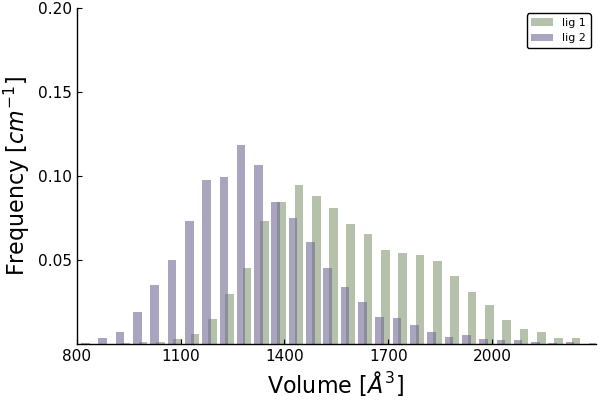

In [143]:
st = 50
fa = .6
range_lig = 800:st:2300
bin_lig = collect(range_lig)

# Histograma ponderado
wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = JUMD.WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);
wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = JUMD.WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

plt_his_vols = bar(bin_lig0_4xcp .+ st/3, his_lig0_4xcp, label = "lig 1",
    
    bar_width = 25, fillcolor = colorant"#849974", fillalpha = fa,
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.2, ylims = (0, .2),
    
    linecolor = false, legend = (.9, .95),
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ")

bar!(bin_lig1_4xcp, his_lig1_4xcp, label = "lig 2", fillalpha = fa,
    bar_width = 25, fillcolor = colorant"#726a95", linecolor = false)

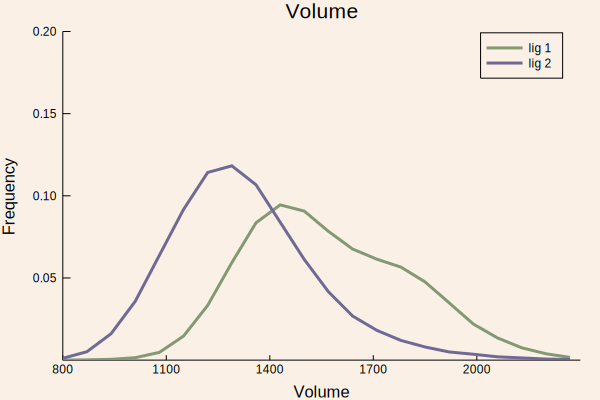

In [80]:
# Suavizado
m_ = 2
ash_vol_0 = ash(trj_vol0, rng = 800:70:2300, m = m_, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_0 = xy(ash_vol_0)
xy_ash_vol_0[2][:] = xy_ash_vol_0[2] .*  (maximum(his_lig0_4xcp) / maximum(xy_ash_vol_0[2]))

ash_vol_1 = ash(trj_vol1, rng = 800:70:2300, m = m_, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_1 = xy(ash_vol_1)
xy_ash_vol_1[2][:] = xy_ash_vol_1[2] .*  (maximum(his_lig1_4xcp) / maximum(xy_ash_vol_1[2]))

plt_his_vols = plot(xy_ash_vol_0, linecolor = colorant"#849974", label = "lig 1", linewidth = 3, 
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.2, ylims = (0, .2),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = (.9, .95),
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

plot!(xy_ash_vol_1, linecolor = colorant"#726a95", label = "lig 2", linewidth = 3)

In [42]:
savefig(plt_his_vols, joinpath(rtdos, "papel", "4", string("4_plt_his_vols_", pdb, ".svg")))

In [82]:
df_datos = hcat([ mean(trj_vol0) ; mean(trj_vol1) ],
    [ std(trj_vol0) ; std(trj_vol1) ])

2×2 Array{Float64,2}:
 1570.7   229.796
 1324.15  204.376

In [115]:
trj_vol0_smooth = [ mean(trj_vol0[i:i+10]) for i = 1:10:length(trj_vol0)-9 ]
trj_vol1_smooth = [ mean(trj_vol1[i:i+10]) for i = 1:10:length(trj_vol1)-9 ]

idx_lig0_smooth = [ idx_lig_0[i] for i = 1:10:length(idx_lig_0)-9 ]
idx_lig1_smooth = [ idx_lig_1[i] for i = 1:10:length(idx_lig_1)-9 ]

grupos = [ fill("lig 1", length(idx_lig0_smooth)) ; fill("lig 2", length(idx_lig1_smooth)) ];

In [125]:
plt_vol_pop = scatter(idx_lig0_smooth, trj_vol0_smooth,  label = "pop 1",
    markersize = 2., markeralpha = .3, markerstrokewidth = .1, seriescolor = colorant"##3DDAD7",
    
    yaxis = "Volumen", xaxis = "Frames", title = "Volume",
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

scatter!(idx_lig1_smooth, trj_vol1_smooth, label = "pop 2",
    markersize = 2., markeralpha = .3, markerstrokewidth = .1, seriescolor = colorant"#2A93D5");

In [126]:
savefig(plt_vol_pop, joinpath(rtdos, "papel", "4", string("3_VolH_", pdb, "_lig.svg")))

## Comparo con los índices separados por proteína

### Idem al próximo, pero en barras. No funca bien
bw = 15
alf = .5
plt_his_vols = bar(bin_vol_prt1 .+ st/4, his_vol_prt1, label = "pop 1", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"##3DDAD7", bar_position = :overlay, bar_width = bw,
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.26, ylims = (0, .25),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_colomr_inside = :linen,
    background_color_legend = :linen, legend = (.9, .95))

bar!(bin_vol_prt2 .- st/4, his_vol_prt2, label = "pop 2", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#2A93D5", bar_position = :overlay, bar_width = bw)

bar!(bin_vol_prt3 .- st/2, his_vol_prt3, label = "pop 3", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#6d138b", bar_position = :overlay, bar_width = bw)

bar!(bin_lig0_4xcp .+ st/4, his_lig0_4xcp, label = "lig 1", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#849974", bar_position = :overlay, bar_width = bw)

bar!(bin_lig1_4xcp .- st/3, his_lig1_4xcp, label = "lig 2", linewidth = 3, fillalpha = alf,
    linecolor = false, fillcolor = colorant"#726a95", bar_position = :overlay, bar_width = bw)

In [84]:
idx_prt1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol1")))[:, 1])
idx_prt2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol2")))[:, 1])
idx_prt3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol3")))[:, 1])
# Junto
idx_prt23 = [ idx_prt2 ; idx_prt3 ]

trj_vol_prt1 = full_trj_vol[idx_prt1]
trj_vol_prt2 = full_trj_vol[idx_prt2]
trj_vol_prt3 = full_trj_vol[idx_prt3]
trj_vol_prt23 = full_trj_vol[idx_prt23];

st = 50
bw = 28
fa = .6
bin_vol = collect(800:st:2300)

wgh_lig = fill(1.0, length(trj_vol_prt1))
bin_vol_prt1, his_vol_prt1 = JUMD.WeightedHist(trj_vol_prt1, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt2))
bin_vol_prt2, his_vol_prt2 = JUMD.WeightedHist(trj_vol_prt2, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt3))
bin_vol_prt3, his_vol_prt3 = JUMD.WeightedHist(trj_vol_prt3, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt23))
bin_vol_prt23, his_vol_prt23 = JUMD.WeightedHist(trj_vol_prt23, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = JUMD.WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = JUMD.WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

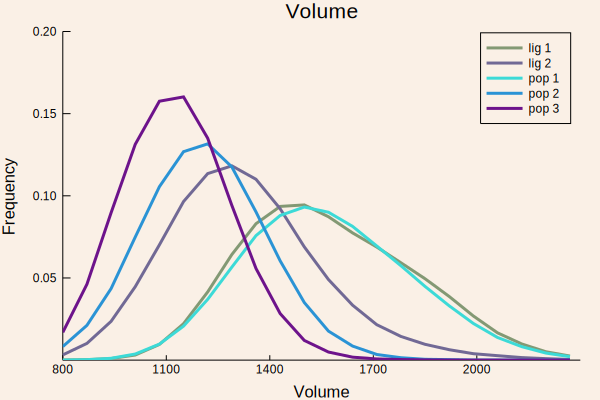

In [86]:
# Suavizado
m_ = 3
ash_vol_0 = ash(trj_vol0, rng = 800:70:2300, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_0 = xy(ash_vol_0)
xy_ash_vol_0[2][:] = xy_ash_vol_0[2] .*  (maximum(his_lig0_4xcp) / maximum(xy_ash_vol_0[2]))

ash_vol_1 = ash(trj_vol1, rng = 800:70:2300, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_1 = xy(ash_vol_1)
xy_ash_vol_1[2][:] = xy_ash_vol_1[2] .*  (maximum(his_lig1_4xcp) / maximum(xy_ash_vol_1[2]))

ash_vol_prt1 = ash(trj_vol_prt1, rng = 800:70:2300, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt1 = xy(ash_vol_prt1)
xy_ash_vol_prt1[2][:] = xy_ash_vol_prt1[2] .*  (maximum(his_vol_prt1) / maximum(xy_ash_vol_prt1[2]))

ash_vol_prt2 = ash(trj_vol_prt2, rng = 800:70:2300, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt2 = xy(ash_vol_prt2)
xy_ash_vol_prt2[2][:] = xy_ash_vol_prt2[2] .*  (maximum(his_vol_prt2) / maximum(xy_ash_vol_prt2[2]))

ash_vol_prt3 = ash(trj_vol_prt3, rng = 800:70:2300, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt3 = xy(ash_vol_prt3)
xy_ash_vol_prt3[2][:] = xy_ash_vol_prt3[2] .*  (maximum(his_vol_prt3) / maximum(xy_ash_vol_prt3[2]))

plt_his_vols = plot(xy_ash_vol_0, linecolor = colorant"#849974", label = "lig 1", linewidth = 3, 
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.2, ylims = (0, .2),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = (.9, .95),
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

plot!(xy_ash_vol_1, linecolor = colorant"#726a95", label = "lig 2", linewidth = 3)
plot!(xy_ash_vol_prt1, linecolor = colorant"#3DDAD7", label = "pop 1", linewidth = 3)
plot!(xy_ash_vol_prt2, linecolor = colorant"#2A93D5", label = "pop 2", linewidth = 3)
plot!(xy_ash_vol_prt3, linecolor = colorant"#6d138b", label = "pop 3", linewidth = 3)

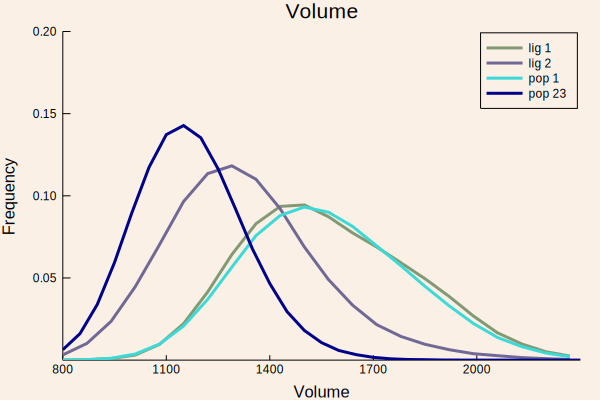

In [88]:
ash_vol_prt23 = ash(trj_vol_prt23, rng = 800:st:2300, m = m_, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt23 = xy(ash_vol_prt23)
xy_ash_vol_prt23[2][:] = xy_ash_vol_prt23[2] .*  (maximum(his_vol_prt23) / maximum(xy_ash_vol_prt23[2]))

plt_his_vols = plot(xy_ash_vol_0, linecolor = colorant"#849974", label = "lig 1", linewidth = 3, 
    
    xticks = 800:300:2100, xlims = (800, 2300),
    yticks = .05:.05:.2, ylims = (0, .2),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = (.9, .95),
    
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

plot!(xy_ash_vol_1, linecolor = colorant"#726a95", label = "lig 2", linewidth = 3)
plot!(xy_ash_vol_prt1, linecolor = colorant"#3DDAD7", label = "pop 1", linewidth = 3)
plot!(xy_ash_vol_prt23, linecolor = colorant"#00008B", label = "pop 23", linewidth = 3)

### RMSD de lig en poblaciones prot. Guardo el frame más similar al avg

In [105]:
rmsd_prt_lig1 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol1_lig")))[2:end, 2]
rmsd_prt_lig2 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol2_lig")))[2:end, 2]
rmsd_prt_lig3 = readdlm(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("rmsd_vol3_lig")))[2:end, 2]

# 1
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol1_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol1_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_prt_lig1) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig1", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 2
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol2_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol2_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_prt_lig2) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig2", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 3
trj_in = Trajectory(joinpath(home, pdb, "poblaciones", string("vol3_", pdb, ".nc")))
in_top_trj = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig", "intra", string("avg_vol3_", pdb, "_lig", ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_prt_lig3) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(
    joinpath(home, pdb, "poblaciones", "lig","intra", string("top_", pdb, "_lig3", ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

#### RMSD de lig en poblaciones lig. Guardo el frame más similar al avg

In [100]:
rmsd_lig0 = readdlm(joinpath(
        home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig0")))[2:end, 2]
rmsd_lig1 = readdlm(joinpath(
        home, pdb, "lig", "poblaciones", "intra", string("rmsd_lig1")))[2:end, 2];

# 0
trj_in = Trajectory(joinpath(home, pdb, "lig", "poblaciones", string("lig0_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("avg_lig0_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_lig0) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("top_lig0_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)

# 1
trj_in = Trajectory(joinpath(home, pdb, "lig", "poblaciones", string("lig1_", pdb, ".nc")))
in_top_trj = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("avg_lig1_", pdb, ".pdb")))
in_top_frm = read(in_top_trj)
in_top = Topology(in_top_frm)
in_frm = read_step(trj_in, argmin(rmsd_lig1) - 1)
set_topology!(in_frm, in_top)
trj_out = Trajectory(joinpath(home, pdb, "lig", "poblaciones", "intra", string("top_lig1_", pdb, ".pdb")), 'w')
write(trj_out, in_frm)
close(trj_out)
close(trj_in)